<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/S12/Assignment%20A/S12_TinyImageNet_ResNet18_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library'
sys.path.append(workingdir)

In [3]:
%matplotlib inline
import torch
import torchvision
import numpy as np


#Below are the created modules
import dnnmodel
import custom_resnet
import train_test
import datatransformation 
import showimages
import displayimages
import  gradcam 
import grad_visualize 
import lr_finder
import lr_range_test
from clr import CyclicLR
from utils import *
import plotresults
from torch.optim.lr_scheduler import StepLR
import datapreparation

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
classes, trainloader, testloader = datapreparation.load('tinyimagenet', 70, batch_size=512, split=True, albumentations=True)


CUDA Available? True


shape: torch.Size([512, 3, 64, 64])
n03937543 n09256479 n01983481 n04265275 n02814533


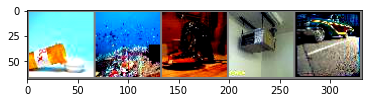

In [5]:
#display.show_random_images(trainloader, classes, 5)
displayimages.show_random_image(trainloader,classes)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = dnnmodel.ResNet18(num_classes=200)
model = net.to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


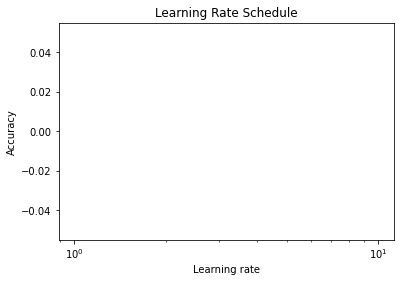

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

#LR Finder Test
criterion = nn.CrossEntropyLoss()
weight_decay = 5e-4

#criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder = lr_range_test.LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader,testloader, start_lr=1e-5, end_lr=2, epochs=5, step_mode="exp")
#lr_finder.range_test(trainloader, testloader, start_lr=1e-4, end_lr=0.02,epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [12]:
best_acc = lr_finder.best_acc
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))
print("Best Loss: %s" % (best_loss))
#args.lr = best_lr

Best Accuracy: 13.145454545454545
Best Learning Rate: 0.00011674202731987852
Best Loss: 0.008176444378766147


In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau

initial_lr = 0.001
max_lr = best_lr
min_lr = max_lr * 0.01

EPOCHS = 50
steps_per_epoch = len(trainloader)
num_steps = steps_per_epoch * EPOCHS
peak_lr_epoch = 5 
pct_start = float (peak_lr_epoch/EPOCHS)
div_factor = float (max_lr/initial_lr)
final_div_factor = float (initial_lr/min_lr)

print("maxlr: ", max_lr)
print("epochs: ", EPOCHS)
print("steps_per_epoch: ", steps_per_epoch)
print("pct_start: ", pct_start)
print("div_factor: ", div_factor)
print("final_div_factor: ", final_div_factor)

#torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=None, epochs=None, steps_per_epoch=None, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, last_epoch=-1)

optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader),epochs=args.epochs, div_factor=10, final_div_factor=1,
                      # pct_start=5/args.epochs, anneal_strategy="linear")

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch=steps_per_epoch, 
                                                pct_start=pct_start, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95, 
                                                div_factor=div_factor, 
                                                final_div_factor=final_div_factor, 
                                                last_epoch=-1)


input_size=(3,32,32)

maxlr:  0.00011674202731987852
epochs:  50
steps_per_epoch:  151
pct_start:  0.1
div_factor:  0.11674202731987852
final_div_factor:  856.5895444491074


In [0]:
def run(l1_decay=0.0, l2_decay=0.0):
  train_losses=[]
  test_losses = []
  train_accs=[]
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  LR_list = []
  EPOCHS = 50
  #args.epochs
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
      LR_list.append(optimizer.param_groups[0]['lr'])
      train_test.train(model, device, trainloader, optimizer,scheduler, epoch,False,best_loss)
      train_test.test(model, device, testloader,criterion, classes, test_losses, test_accs,misclassified_imgs,correct_imgs,epoch==EPOCHS-1)        
      #scheduler.step()

In [0]:
# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs,correct_imgs = run(l1_decay=3e-06, l2_decay=0.001)

  0%|          | 0/151 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.001


Loss=3.7836687564849854 Batch_id=150 Accuracy=15.83: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 5206/33000 (15.78%)

EPOCH: 1 LR: 0.001


Loss=3.619903326034546 Batch_id=150 Accuracy=17.99: 100%|██████████| 151/151 [06:01<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 5587/33000 (16.93%)

EPOCH: 2 LR: 0.001


Loss=3.5750722885131836 Batch_id=150 Accuracy=20.11: 100%|██████████| 151/151 [06:01<00:00,  2.39s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 6623/33000 (20.07%)

EPOCH: 3 LR: 0.001


Loss=3.273050546646118 Batch_id=150 Accuracy=22.02: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 7156/33000 (21.68%)

EPOCH: 4 LR: 0.001


Loss=3.1672730445861816 Batch_id=150 Accuracy=23.94: 100%|██████████| 151/151 [06:01<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 7229/33000 (21.91%)

EPOCH: 5 LR: 0.001


Loss=3.397529363632202 Batch_id=150 Accuracy=26.01: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0066, Accuracy: 7834/33000 (23.74%)

EPOCH: 6 LR: 0.001


Loss=3.1300723552703857 Batch_id=150 Accuracy=27.58: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 8348/33000 (25.30%)

EPOCH: 7 LR: 0.001


Loss=2.9768078327178955 Batch_id=150 Accuracy=29.03: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 8875/33000 (26.89%)

EPOCH: 8 LR: 0.001


Loss=3.015669584274292 Batch_id=150 Accuracy=30.77: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 9059/33000 (27.45%)

EPOCH: 9 LR: 0.001


Loss=2.9038383960723877 Batch_id=150 Accuracy=31.98: 100%|██████████| 151/151 [06:02<00:00,  2.40s/it]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 9780/33000 (29.64%)

EPOCH: 10 LR: 0.001


Loss=2.9623358249664307 Batch_id=54 Accuracy=33.60:  36%|███▋      | 55/151 [02:13<03:50,  2.40s/it]

In [0]:
showimages.show_predicted_actual(model, device, testloader, classes)